In [1]:
from sortedcontainers import SortedSet
from math import sqrt
import numpy as np
## https://stackoverflow.com/questions/8875706/heapq-with-custom-compare-predicate/8875823
# Priority Queue with custom comparator
class MyPriorityQueue(object):
    # compare1 is the function that will return f(n)-> sort in ascending order of f(n)
    # compare2 is the function that will return g(n)-> sort in ascending order of g(n) if f(n) is same
    def __init__(self, current_heuristic, target):
        self.current_heuristic = current_heuristic
        self._data = SortedSet()
        self.target = target
        self.g = dict()
        self.h = dict()
    def __len__(self):
        return len(self._data)
    #### It is required to update g(n) and h(n) before pushing the node into the priority queue
    def push(self, item):
        node = (self.calculate_priority(item), self.get_heuristic(item), item)
        self._data.add(node)
    def pop(self):
        node = self._data.pop(0)[2]
        return node
    def manhattan_distance(self, x, y): # Manhattan Distance -> heuristic = |x1-x2| + |y1-y2|
        return abs(x[0]-y[0])+abs(x[1]-y[1])
    def euclidean_distance(self, x, y): # Euclidean Distance -> heuristic = sqrt( (x1-x2)**2 + (y1-y2)**2 )
        return sqrt( (x[0]-y[0])**2 + (x[1]-y[1])**2 )
    def chebyshev_distance(self, x, y): # Chebyshev Distance -> heuristic = max(|x1-x2|, |y1-y2|)
        return max(abs(x[0]-y[0]), abs(x[1]-y[1]))
    def get_heuristic(self, x):  # returns the value of heuristic based on the heuristic function
        measure = self.current_heuristic
        if measure == 'm': # if h is manhattan
            self.h[x] = self.manhattan_distance(x, self.target)
        elif measure == 'e': # if h is euclidean
            self.h[x] = self.euclidean_distance(x, self.target)
        elif measure == 'c': # if c is chebyshev
            self.h[x] = self.chebyshev_distance(x, self.target)
        return self.h[x]
    def calculate_priority(self, x): # calculates priority for each cell - distance from cell to target
        return self.g[x] + self.get_heuristic(x)

class GridWorld3:
    def __init__(self, grid, start, target, n, m, agent_grid = None ):
        self.n = n # denotes the number of rows
        self.m = m # denotes the number of columns
        self.start = start # denotes the start coordinate of the grid
        self.target = target # denotes the target coordinate of the grid
        self.trajectory = [] # denotes the trajectory of the agent in the grid
        self.grid = grid # denotes the full knowledge of the grid
        if agent_grid is None:
            self.agent_grid = np.full((n,n),'.')
        else:
            self.agent_grid = agent_grid
        self.sum_num_cells_processed = 0
        self.num_bumps = 0
    def a_star(self, source, current_heuristic = 'm'):
        dirx = [-1, 1, 0, 0] ## calculates the neighbours of the current node
        diry = [0, 0, 1, -1] ## calculates the neighbours of the current node
        visited = set() ## contains the nodes that have already been added in priority queue
        closed_list = set() ## contains the nodes that have been popped from priority queue
        open_list = MyPriorityQueue(current_heuristic, self.target) ## stores the visited nodes and pops it out according to it's priority
        planned_path = [] ## Stores the path that the agent has planned according to it's current knowledge
        open_list.g[source]=0
        open_list.calculate_priority( source)
        open_list.push( source) ## This function runs in O(logn)
        visited.add(source)#visited[source] = 1
        parent = {} ## stores the parent of each node that is visited
        parent[source] = None
        while(len(open_list)>0):
            curr = open_list.pop()
            if(curr in closed_list):
                continue
            self.sum_num_cells_processed = self.sum_num_cells_processed + 1
            closed_list.add(curr)
            if(curr[0] == self.target[0] and curr[1] == self.target[1]):
                break
            for i in np.arange(4):
                childx = curr[0] + dirx[i]
                childy = curr[1] + diry[i]
                child = (childx, childy)
                if(childx>=0 and childx<self.m and childy>=0 and childy<self.n and (child not in closed_list) and self.agent_grid[childx][childy]!='X'):
                    if(child not in visited):
                        visited.add(child)
                        parent[child] = curr
                        open_list.g[child] = open_list.g[curr]+1
                        open_list.calculate_priority(child)
                        open_list.push(child) 
                    else:
                        if open_list.g[curr]+1<open_list.g[child]:
                            parent[child] = curr
                            open_list._data.discard(child)
                            open_list.g[child] = open_list.g[curr]+1
                            open_list.calculate_priority(child)
                            open_list.push(child)
        if(self.target not in visited):
            return []
        curr = self.target
        while(curr != source):
            planned_path.append(curr)
            curr = parent[curr]
        planned_path.append(source)
        return planned_path[::-1]
    
    def check_planned_path(self, planned_path):
        dirx = [-1, 1, 0, 0]
        diry = [0, 0, -1, 1]
        n = len(planned_path)
        traversed_path = []
        for i in np.arange(n):
            currx = planned_path[i][0]
            curry = planned_path[i][1]
            if(self.grid[currx][curry] == 'X'):
                self.agent_grid[currx][curry] = self.grid[currx][curry]
                self.num_bumps+=1
                break
            traversed_path.append((currx,curry))
        return traversed_path
    
    ## This is the function that computes the path that repeated a-star traverses
    def compute_path(self):
        path = []
        curr = self.start
        while(curr != self.target):
            planned_path = self.a_star(curr)
            if( len(planned_path) == 0 ):
                return []
            traversed_path = self.check_planned_path(planned_path)
            n = len(traversed_path)
            path.append(traversed_path)
            if(traversed_path[n-1] == self.target):
                break
            curr = traversed_path[n-1]
        return path

In [3]:
import numpy as np
p_values = np.linspace(0,0.33,34)

In [5]:
# Density vs Average Trajectory Length
# Density vs Average (Length of Trajectory / Length of Shortest Path in Final Discovered Gridworld (FDG) )
from tqdm import tqdm
import numpy as np
cnt = 0
p_values = np.round(p_values,2)
result_x = p_values[1:50]
avg_len_trajectory = []
avg_traj_sp_fdg = [] # Density vs Average (Length of Trajectory / Length of Shortest Path in Final Discovered Gridworld (FDG) )
avg_sp_fdg_sp_kn = [] # Average of shortest path in final discovered grid vs shortest path in known grid
avg_num_cells_a_star = []
avg_num_bumps = []
samples = 250
def update_final_discovered_grid(final_discovered_grid, rep_a_trajectory, grid):
    m = len(final_discovered_grid)
    n = len(final_discovered_grid[0])
    dirx = [-1, 1, 0, 0]
    diry = [0, 0, -1, 1]
    for x in rep_a_trajectory:
        for i in np.arange(len(x)):
            pos = x[i]
            final_discovered_grid[pos[0]][pos[1]] = grid[pos[0]][pos[1]]
    return final_discovered_grid
def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data_Proj_2/'+'p'+str(p)+'.txt') as f:
        print('Started for p: ',p)
        grid_data = f.readlines()
        freq = 0
        sum_traj_len = 0
        ratio1 = 0 # Length of trajectory / Length of Shortest Path in Final Discovered GridWorld
        ratio2 = 0
        sum_cell_processed = 0
        sum_bumps = 0
        cnt = 0
        for s in grid_data:
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            while(i<m*n):
                grid.append(list(s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gw = GridWorld3(grid,(0,0),(100,100),101,101)
            ## Calculating trajectory length in agent's world
            rep_a_trajectory = gw.compute_path() # Length1
            reap_a_traj_len = calculate_path_length(rep_a_trajectory)
            sum_traj_len = sum_traj_len + reap_a_traj_len 
            ## Calculating trjaectory length in final discovered grid
            final_discovered_grid = np.full((101,101),'X')
            final_discovered_grid = update_final_discovered_grid(final_discovered_grid, rep_a_trajectory, grid)
            gw_final_discovered = GridWorld3(final_discovered_grid, (0,0), (100,100), 101, 101, agent_grid = final_discovered_grid)
            shortest_path_final_discovered = gw_final_discovered.a_star((0,0),'m') #Length2
            # Graph2 ratio1 = Avg( Length1/Length2 ) vs p
            ratio1 = ratio1 + reap_a_traj_len/len(shortest_path_final_discovered)

            #Calculaing shortest path length in Full Known grid
            gw_full_known = GridWorld3(grid, (0,0),(100,100), 101, 101, agent_grid = grid)
            shortest_path_full_known = gw_full_known.a_star((0,0),'m')# Length3
            # Graph3 -> ratio2 = Avg(Length2/Length3) vs p
            if(len(shortest_path_full_known)==0):
                print(grid)
            ratio2 = ratio2 + len(shortest_path_final_discovered)/len(shortest_path_full_known)
            #Graph 4 -> p vs Avg cell processed
            sum_cell_processed = sum_cell_processed + gw.sum_num_cells_processed
            sum_bumps = sum_bumps + gw.num_bumps
            cnt+=1
            if(cnt == samples):
                break
        avg_len_trajectory.append(sum_traj_len/samples)
        avg_traj_sp_fdg.append(ratio1/samples)
        avg_sp_fdg_sp_kn.append(ratio2/samples)
        avg_num_cells_a_star.append(sum_cell_processed/samples)
        avg_num_bumps.append(sum_bumps/samples)
        print(sum_bumps/samples)

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

Started for p:  0.01


  6%|████▉                                                                              | 2/34 [00:03<00:59,  1.87s/it]

1.956
Started for p:  0.02


  9%|███████▎                                                                           | 3/34 [00:08<01:35,  3.07s/it]

4.068
Started for p:  0.03


 12%|█████████▊                                                                         | 4/34 [00:14<02:03,  4.13s/it]

6.068
Started for p:  0.04


 15%|████████████▏                                                                      | 5/34 [00:21<02:29,  5.15s/it]

8.524
Started for p:  0.05


 18%|██████████████▋                                                                    | 6/34 [00:29<02:55,  6.27s/it]

11.028
Started for p:  0.06


 21%|█████████████████                                                                  | 7/34 [00:40<03:27,  7.68s/it]

13.852
Started for p:  0.07


 24%|███████████████████▌                                                               | 8/34 [00:52<03:53,  9.00s/it]

15.568
Started for p:  0.08


 26%|█████████████████████▉                                                             | 9/34 [01:05<04:16, 10.24s/it]

19.4
Started for p:  0.09


 29%|████████████████████████                                                          | 10/34 [01:19<04:31, 11.31s/it]

21.88
Started for p:  0.1


 32%|██████████████████████████▌                                                       | 11/34 [01:35<04:51, 12.67s/it]

24.804
Started for p:  0.11


 35%|████████████████████████████▉                                                     | 12/34 [01:51<05:04, 13.83s/it]

28.144
Started for p:  0.12


 38%|███████████████████████████████▎                                                  | 13/34 [02:10<05:20, 15.25s/it]

31.044
Started for p:  0.13


 41%|█████████████████████████████████▊                                                | 14/34 [02:29<05:32, 16.65s/it]

34.888
Started for p:  0.14


 44%|████████████████████████████████████▏                                             | 15/34 [02:52<05:52, 18.55s/it]

38.528
Started for p:  0.15


 47%|██████████████████████████████████████▌                                           | 16/34 [03:16<06:01, 20.08s/it]

42.748
Started for p:  0.16


 50%|█████████████████████████████████████████                                         | 17/34 [03:43<06:17, 22.18s/it]

45.96
Started for p:  0.17


 53%|███████████████████████████████████████████▍                                      | 18/34 [04:11<06:21, 23.83s/it]

49.236
Started for p:  0.18


 56%|█████████████████████████████████████████████▊                                    | 19/34 [04:41<06:24, 25.64s/it]

54.28
Started for p:  0.19


 59%|████████████████████████████████████████████████▏                                 | 20/34 [05:14<06:33, 28.08s/it]

60.16
Started for p:  0.2


 62%|██████████████████████████████████████████████████▋                               | 21/34 [05:49<06:32, 30.16s/it]

65.344
Started for p:  0.21


 65%|█████████████████████████████████████████████████████                             | 22/34 [06:27<06:28, 32.39s/it]

71.424
Started for p:  0.22


 68%|███████████████████████████████████████████████████████▍                          | 23/34 [07:08<06:23, 34.84s/it]

76.536
Started for p:  0.23


 71%|█████████████████████████████████████████████████████████▉                        | 24/34 [07:50<06:10, 37.08s/it]

83.168
Started for p:  0.24


 74%|████████████████████████████████████████████████████████████▎                     | 25/34 [08:35<05:56, 39.58s/it]

87.664
Started for p:  0.25


 74%|████████████████████████████████████████████████████████████▎                     | 25/34 [09:08<03:17, 21.95s/it]


KeyboardInterrupt: 

In [4]:
result_x[:-1]

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])

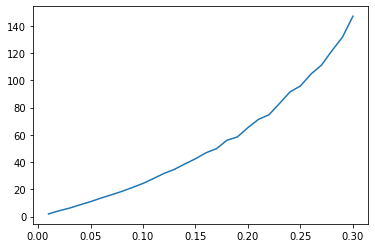

In [5]:
import matplotlib.pyplot as plt
plt.plot(result_x[:],avg_num_bumps)

In [6]:
avg_len_trajectory

[202.936,
 205.416,
 207.44,
 210.048,
 212.016,
 215.352,
 217.736,
 220.496,
 223.768,
 228.256,
 232.52,
 236.424,
 239.776,
 244.768,
 250.104,
 253.8,
 258.832,
 266.568,
 268.952,
 279.416,
 286.52,
 290.936,
 302.64,
 315.648,
 319.296,
 334.168,
 343.96,
 359.344,
 375.24,
 400.832]

In [8]:
# import pickle
# with open('agent_2_avg_bumps.pkl', 'wb') as f:
#     pickle.dump(avg_num_bumps, f)